In [22]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import os
import random

import numpy as np
import torch
import scipy.io

from experiment import mRNN
from experiment import michaels_load
from experiment import stim
from experiment import utils

#CUDA = torch.device(0)
CUDA = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       cuda=CUDA)

In [24]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA, with_label=True)

# Dataset items are:
#   (michaels network input, trial end indicator, trial len (scalar),
#    target output, class label)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [31]:
# The whole dataset
all_data = next(iter(dataloader))

din = all_data[0]
dout = all_data[-2]
trial_end = all_data[1]

batch_size = din.shape[0]
trial_len = din.shape[1]
out_dim = dout.shape[-1]


# Batch idx, time, feature
print("Input shape:", din.shape)

# Batch idx, time, muscle idx
print("Output shape:", dout.shape)

Input shape: torch.Size([502, 341, 21])
Output shape: torch.Size([502, 341, 50])


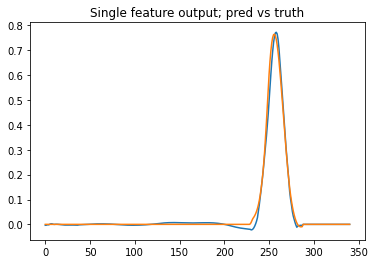

In [34]:
# Ground truth vs. un-lesioned network

preds = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    preds = preds.cuda(CUDA)

mike.reset()

for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    preds[:, tidx, :] = mike_out

preds = utils.trunc_to_trial_end(preds, trial_end)

bidx = random.randrange(batch_size)
fidx = random.randrange(out_dim)
plt.plot(preds[bidx,:,fidx].detach().numpy())
plt.plot(dout[bidx, :, fidx].detach().numpy())
plt.title("Single feature output; pred vs truth")
plt.show()

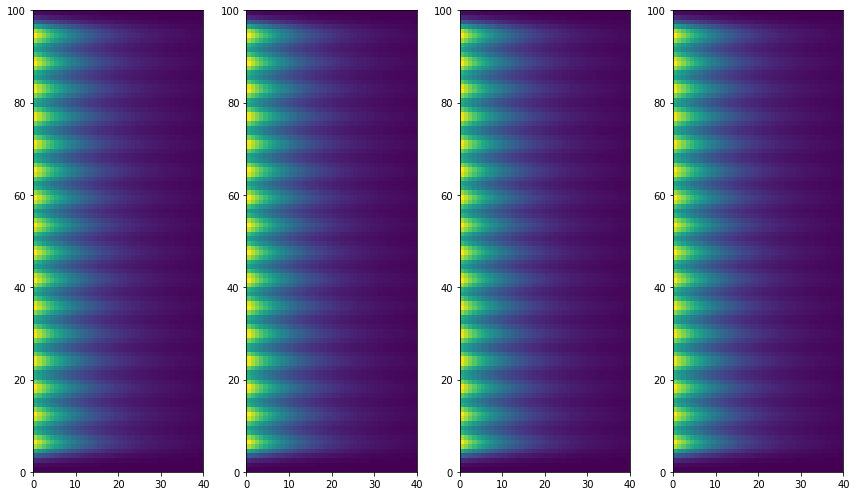

In [15]:
# Stimulation

num_stim_electrodes = 16
fig,axs = plt.subplots(1,4, figsize=(12,7))

stimulus = stim.StimulusGaussianExp(num_stim_electrodes, 100, sigma=1.875, batch_size=4, decay=0.09)
params = torch.tensor(np.array([random.uniform(2.5, 2.5) for _ in range(4 * num_stim_electrodes)]).reshape(
    4, -1)).float()
stimulus.add(params)

stims = [np.zeros((100, 40)) for _ in range(4)]
s = stimulus.get_next()
tidx = 0
while torch.sum(s) > 0.0 and tidx < 40:
    for bidx in range(4):
        stims[bidx][:, tidx] = s[bidx,:100]
    s = stimulus.get_next()
    tidx += 1

for bidx in range(4):
    axs[bidx].pcolormesh(stims[bidx][:,:])

fig.tight_layout()
plt.show()

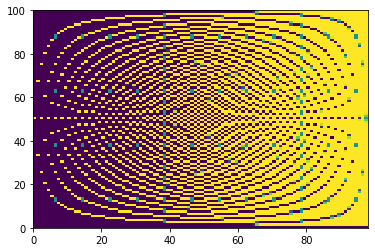

In [18]:
from scipy.stats import norm
dn = norm(0, 0.075)

out = torch.zeros(100, 98).float()
for cidx in range(1, 99):
    cur_stim = stim.StimulusGaussianExp(cidx, 100, sigma=0.075, batch_size=1, decay=0.09)
    aw = cur_stim.get_neuron_weights()
        
    vin = torch.ones(cidx)

    res = aw @ vin
    out[:, cidx-1] = res[:]
    
plt.pcolormesh(out.detach().numpy())

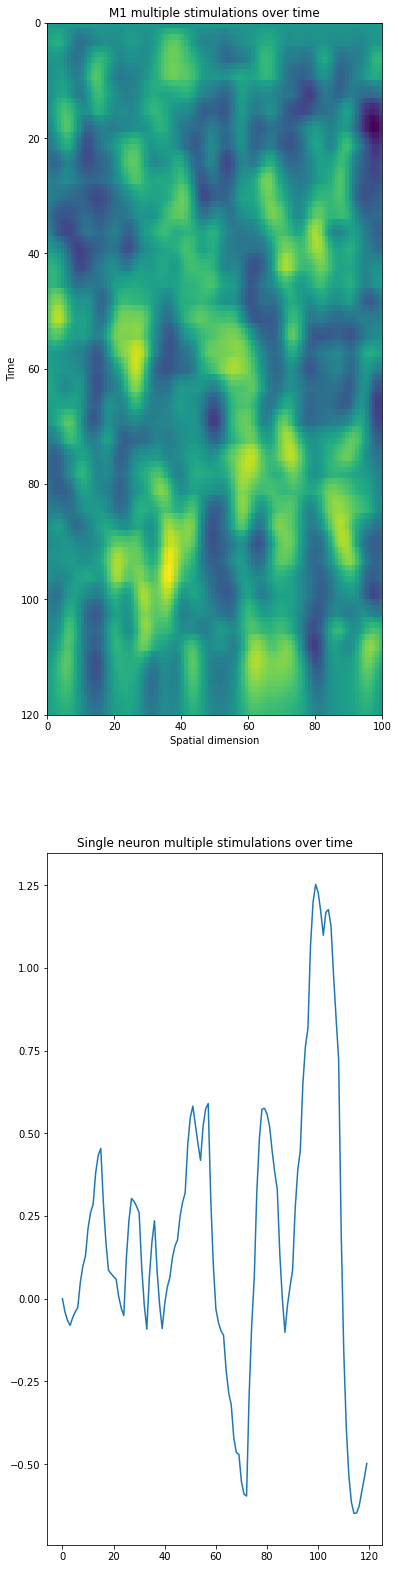

In [20]:
num_stim_electrodes = 64


stims = np.zeros((100,120))
sc = stim.StimulusGaussian(num_stim_electrodes, 100)
sc.reset(batch_size=1)

for tidx in range(120):
    if not (tidx % 3) and tidx < 110:
        params = np.array([random.uniform(-2.5,2.5) for _ in range(num_stim_electrodes)]).reshape(1, num_stim_electrodes)
        sc.add(params)
    stims[:,tidx] = sc.get_next()[0, :100]
    
fig, ax = plt.subplots(2,1, figsize=(6,28))
ax[0].pcolormesh(stims[:100,:].T)
ax[0].set_title("M1 multiple stimulations over time")
ax[0].set_xlabel("Spatial dimension")
ax[0].set_ylabel("Time")
ax[0].set_ylim(ax[0].get_ylim()[::-1])

ax[1].plot(stims[30,:])
ax[1].set_title("Single neuron multiple stimulations over time")

plt.show()

Input shape: (21, 286)
Output shape: (50, 286)
Predicted output shape: torch.Size([1, 286, 50])


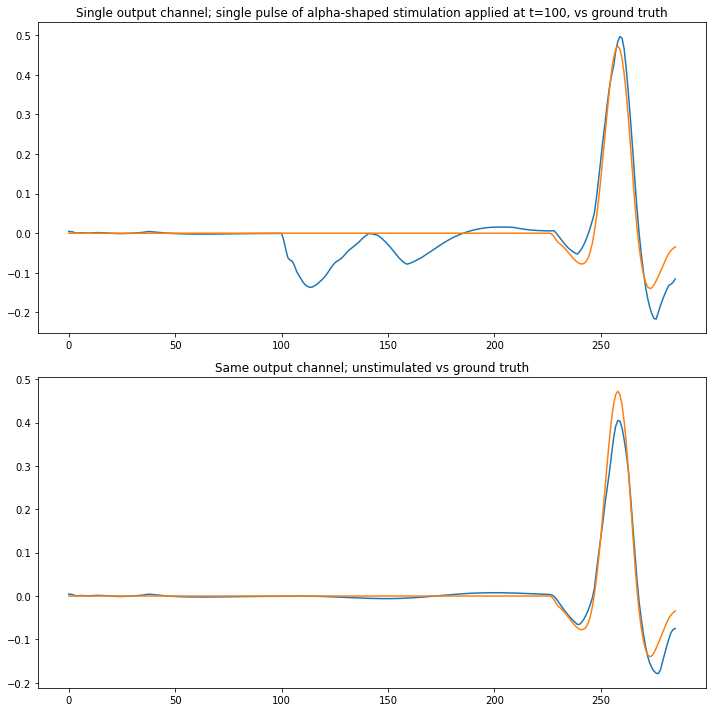

In [22]:
import experiment.observer as observer
sc = stim.StimulusGaussian(num_stim_electrodes, 100)
sc.reset(batch_size=1)
ob = observer.ObserverPassthrough(100)
rnn = mRNN.MichaelsRNN(init_data_path=network_path, stimulus=sc)

idx = 1
example_in = network_data['inp'][idx]
print("Input shape:", example_in.shape)
example_out = network_data['targ'][idx]
print("Output shape:", example_out.shape)

data = utils.fill_jagged_array([example_in,])                                                                                 
steps = data.shape[1]
pred_out = torch.empty((1, steps, rnn.output_dim))
obs = np.zeros((steps,))
for tidx in range(steps):                                                                                                
    
    if tidx == 100:
        params = np.array([random.uniform(-7.5,7.5) for _ in range(num_stim_electrodes)]).reshape(1, -1)
        rnn.stimulate(params)
    cur = data[:,tidx,:] 
    pred_out[0,tidx,:] = rnn(cur.T)
    o = rnn.observe(ob)
    obs[tidx] = o[0][0, 32]

print("Predicted output shape:", pred_out.shape)

fig,axs = plt.subplots(2,1, figsize=(10,10))
axs[0].plot(pred_out[0,:,32].detach().numpy())
axs[1].plot(pred_out_top[0,:,32].detach().numpy())
axs[0].plot(example_out[32,:])
axs[1].plot(example_out[32,:])
axs[0].set_title("Single output channel; single pulse of alpha-shaped stimulation applied at t=100, vs ground truth")
axs[1].set_title("Same output channel; unstimulated vs ground truth")
fig.tight_layout()
plt.show()